In [2]:
import re
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchmetrics import F1Score
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [3]:
# Define device for torch
device = torch.device("cpu")
# MPS for Apple Silicon GPUs
if torch.mps.is_available():
   print("MPS is available")
   device = torch.device("mps")

# CUDA for Nvidia GPUs
if torch.cuda.is_available():
   print("CUDA is available")
   device = torch.device("cuda")
print(device)

CUDA is available
cuda


amdgpu.ids: No such file or directory


In [4]:
def count_parameters(model):
    for name, module in model.named_modules():
        params = sum(p.numel() for p in module.parameters())
        print(f"{name}: {params} parameters")

# Dataset and Dataloader

To investigate: Normalization or other transforms

In [5]:
class NormalizeECG:
    def __call__(self, tensor):
        # Z-score normalization per lead
        means = tensor.mean(dim=1, keepdim=True)
        stds = tensor.std(dim=1, keepdim=True)
        return (tensor - means) / (stds + 1e-8)

In [6]:
class ECGDataset(Dataset):
    def __init__(self, path="data/ecg", diagnoses='data/diagnoses.csv', transform=None):
        # Load and prepare labels
        self.labels_df = pd.read_csv(diagnoses)

        self.labels_df['ID'] = self.labels_df['ID'].astype(str).str.replace(r'\D', '', regex=True) # Remove the JS
        self.labels_df.set_index('ID', inplace=True)
        self.num_classes = self.labels_df.shape[1]
        print(f'Number of classes: {self.num_classes}')

        self.transform = transform
        self.cache = {}

    def get_pos_weights(self):
        # Compute counts
        pos_counts = self.labels_df.sum()
        neg_counts = len(self.labels_df) - pos_counts

        # Calculate pos_weight = #neg / #pos for each class
        pos_weight = (neg_counts / pos_counts).values

        # Move to device
        pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32, device=device)
        return pos_weight_tensor
    
    def get_num_classes(self):
        return self.num_classes

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        
        try:
            # Access the row through iloc of the index,
            # Use the ID to make filepath
            ID = self.labels_df.iloc[idx].name

            file_path = f'data/ecg/{ID}.csv'
            
            # Load ECG data
            df = pd.read_csv(file_path)
            ecg_data = df.drop(columns=['time']).values
            tensor = torch.tensor(ecg_data, dtype=torch.float32).T  # (leads, timesteps)
            
            if self.transform:
                tensor = self.transform(tensor)
                
            # Get corresponding label

            label_values = self.labels_df.loc[ID].values  # Get all label columns
            label = torch.tensor(label_values, dtype=torch.float32)  # Use float for multi-label

            return tensor, label
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            # Return zero tensor and -1 label placeholder
            return torch.zeros((12, 5000), dtype=torch.float32), torch.full((self.num_classes,), -1, dtype=torch.float32)

# Basic Transformer

## Getting pos_weights for loss function

In [7]:
dataset = ECGDataset(path="data/ecg", diagnoses='data/diagnoses_balanced.csv')
data, label = dataset.__getitem__(23423)
print(data.shape)
print(label.shape)
dataset.get_pos_weights()

Number of classes: 5
torch.Size([12, 5000])
torch.Size([5])


tensor([3.1199, 3.1205, 3.1199, 3.1205, 3.1205], device='cuda:0')

In [8]:
class ECGTransformer(nn.Module):
    def __init__(self, d_model, num_classes=63, nhead=8, num_encoder_layers=2, dim_feedforward=2048):
        super().__init__()
        
        # Define encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=dim_feedforward, batch_first=True)

        # Encoder stack
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        encoded = self.transformer(x)
        # encoded shape: (batch_size, seq_len, d_model)
        # Pick out only the last in the sequence for classification
        encoded = encoded[:, -1, :]
        result = self.classifier(encoded)
        return result

In [9]:
model = ECGTransformer(d_model=12, nhead=4, num_classes=63, num_encoder_layers=6, dim_feedforward=512)
print(model)
count_parameters(model)

ECGTransformer(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=12, out_features=63, bias=True)
)
: 81723 parameters
transformer: 80904 parameters
transformer.layers: 80904 parameters
transformer.layers.0: 13484 parameters
transformer.layers.0.self_attn: 624 parameters
transformer.layers.0.self_attn.out_proj:

In [10]:
inputs = torch.rand((2, 5000, 12))
out = model(inputs)
print(out.shape)
print(out[0])

torch.Size([2, 63])
tensor([-0.2625, -1.1164, -0.5830, -0.6790,  0.0719,  1.2879, -0.2624, -0.4590,
        -0.3241, -0.8039,  1.1029,  1.1848, -0.8333,  0.8893, -0.9034, -0.5469,
         0.2768,  0.8913, -0.1045,  0.0727, -0.1266, -0.7757, -0.0875, -0.4449,
        -0.6168, -0.2931,  0.4948,  0.4899, -0.0423, -0.2451, -0.1874, -0.4029,
         0.1387,  0.0123,  0.2842,  0.4697, -0.0631, -0.8561,  1.2558, -0.6434,
         0.2504,  0.4545, -0.2403, -0.7965,  0.6444,  1.2127, -0.7039,  0.6348,
         0.2380,  0.8641,  0.8080,  0.6381,  0.5601,  0.5856,  0.0776,  0.4655,
        -0.4387,  0.8512,  0.8403, -0.2318, -0.2688,  0.0069,  0.3510],
       grad_fn=<SelectBackward0>)


# An embedding model 
that uses convolution

Convolution turning 12 channels to 128, repeated to transfer forward 200ms.


In [11]:
class ECGEmbeddings_old(nn.Module):
    def __init__(self, d_input, d_model, n_conv_layers=8):
        super().__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(d_model if i>0 else d_input, d_model, 51, stride=1, padding='same')
            for i in range(n_conv_layers)
        ])
        self.activation = nn.ReLU(inplace=False)  # Important for checkpointing

    def forward(self, x):
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            if i < len(self.conv_layers) - 1:
                x = self.activation(x)

        if not x.requires_grad:
            x = x.detach().requires_grad_(True)

        return x

In [12]:
class ECGEmbeddings(nn.Module):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.conv_layers = nn.ModuleList()
        in_channels = d_input
        out_channels = d_input

        # Dynamically adjust the number of channels to reach d_model
        while out_channels < d_model:
            out_channels = min(d_model, out_channels * 2)  # Double channels, but cap at d_model
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, 1, stride=1, padding='same'))
            in_channels = out_channels

        self.activation = nn.ReLU(inplace=False)  # Important for checkpointing

    def forward(self, x):
        for i, conv in enumerate(self.conv_layers):
            x = conv(x)
            if i < len(self.conv_layers) - 1:  # Apply activation except for the last layer
                x = self.activation(x)

        if not x.requires_grad:
            x = x.detach().requires_grad_(True)

        return x

In [13]:
embedding_model = ECGEmbeddings(d_input=12, d_model=256)
print(embedding_model)
count_parameters(embedding_model)

ECGEmbeddings(
  (conv_layers): ModuleList(
    (0): Conv1d(12, 24, kernel_size=(1,), stride=(1,), padding=same)
    (1): Conv1d(24, 48, kernel_size=(1,), stride=(1,), padding=same)
    (2): Conv1d(48, 96, kernel_size=(1,), stride=(1,), padding=same)
    (3): Conv1d(96, 192, kernel_size=(1,), stride=(1,), padding=same)
    (4): Conv1d(192, 256, kernel_size=(1,), stride=(1,), padding=same)
  )
  (activation): ReLU()
)
: 74248 parameters
conv_layers: 74248 parameters
conv_layers.0: 312 parameters
conv_layers.1: 1200 parameters
conv_layers.2: 4704 parameters
conv_layers.3: 18624 parameters
conv_layers.4: 49408 parameters
activation: 0 parameters


# Combining together embedding with transformer

In [14]:
class ECGCombined(nn.Module):
    def __init__(self, d_input, d_model, num_classes=63, nhead=8, num_encoder_layers=2, dim_feedforward=2048):
        super().__init__()
        self.num_classes = num_classes
        
        self.embedding_model = ECGEmbeddings(d_input, d_model)
        self.transformer = ECGTransformer(d_model, num_classes, nhead, num_encoder_layers, dim_feedforward)

    def forward(self, x):
        x = self.embedding_model(x)
        x = x.permute(0, 2, 1)       # Reshape to (batch_size, seq_len, d_model)
        x = self.transformer(x)
        return x

# Trainer class

In [22]:
def find_optimal_thresholds(y_true, y_probs, thresholds=np.arange(0.05, 0.95, 0.05)):
    """
    Finds optimal threshold for each class based on F1 score.
    """
    n_classes = y_true.shape[1]
    best_thresholds = []
    for i in range(n_classes):
        best_thresh = 0.5
        best_f1 = 0
        for t in thresholds:
            preds = (y_probs[:, i] >= t).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
        best_thresholds.append(best_thresh)
    return np.array(best_thresholds)


In [26]:
class Trainer:
    def __init__(self, model, device, pos_weights=None, accum_steps=4, checkpoint_interval=256, lr=1e-4,
                 resume_checkpoint=None):
        self.model = model
        self.device = device
        self.accum_steps = accum_steps
        self.checkpoint_interval = checkpoint_interval
        
        # Initialize essential components
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1 = F1Score(task='multilabel', num_labels=self.model.num_classes, average=None)
        self.loss = nn.BCEWithLogitsLoss(pos_weight=pos_weights)   
        self.accum_loss = 0.0
        self.loss_history = []
        self.acc_history = []
        self.batch_count = 0
        self.start_epoch = 0
        self.start_batch = 0
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',              # maximize F1
            factor=0.5,              # halve the LR
            patience=2,              # after 2 stagnating checkpoints
            threshold=0.001,
            verbose=True
        )

        if resume_checkpoint:
            self._load_checkpoint(resume_checkpoint)

    def _load_checkpoint(self, checkpoint_path):
        """Load training state from checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
        
        # Essential parameters
        self.model.load_state_dict(checkpoint['model_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        
        # Training progress
        self.loss_history = checkpoint['loss_history']
        self.acc_history = checkpoint['acc_history']
        self.batch_count = checkpoint.get('batch_count', 0)
        self.start_epoch = checkpoint['epoch']
        self.start_batch = checkpoint.get('batch', 0) + 1
        
        # Configurations
        self.checkpoint_interval = checkpoint.get('checkpoint_interval', 
                                                 self.checkpoint_interval)
        
        print(f"Resuming from epoch {self.start_epoch} batch {self.start_batch}")

    def train(self, train_dataloader, test_dataloader, num_epochs, save_path="training_progress"):
        os.makedirs(save_path, exist_ok=True)
        self.model.train()
        
        for epoch in range(self.start_epoch, num_epochs):
            for batch_idx, (inputs, labels) in enumerate(train_dataloader):
                if batch_idx < self.start_batch:
                    continue
                
                
                # Forward pass
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels) / self.accum_steps

                # Backward pass
                loss.backward()

                # Every batch
                self.accum_loss += loss.item()
                self.batch_count += 1
                
                # Every accum_steps
                if (batch_idx + 1) % self.accum_steps == 0:
                    self._update_parameters()
                    
                    # Save loss
                    avg_loss = self.accum_loss
                    self.loss_history.append([self.batch_count, avg_loss])
                    self.accum_loss = 0.0

                    print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx+1}/{len(train_dataloader)} | "
                        f"Avg Loss: {avg_loss:.4f}")

                # Every checkpoint_interval
                if self.batch_count % self.checkpoint_interval == 0:
                    acc = self.evaluate(test_dataloader)
                    self.acc_history.append([self.batch_count, acc])

                    # Scheduler step based on F1 macro average
                    avg_f1 = np.mean(acc["f1_per_class"])
                    self.scheduler.step(avg_f1)

                    self._save_checkpoint(save_path, epoch, batch_idx)
                
                # Sanity checks
                if self.batch_count % 128 == 0:
                    probs = torch.sigmoid(outputs)
                    print("Example probs:", probs[0].detach().cpu().numpy())
                    print("Ground truth :", labels[0].cpu().numpy())
                
                del inputs, labels, outputs, loss
            self.start_batch = 0

    def evaluate(self, dataloader):
        self.model.eval()
        total_samples = 0
        num_classes = self.model.num_classes
        mismatches_per_class = torch.zeros(num_classes, device=self.device)

        all_probs = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())
                total_samples += inputs.size(0)

        # Stack across batches
        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        # Find optimal thresholds
        optimal_thresholds = find_optimal_thresholds(all_labels, all_probs)
        print("🔍 Optimal thresholds per class:", optimal_thresholds)

        # Apply thresholds
        preds = (all_probs >= optimal_thresholds).astype(int)

        # Metrics
        f1_score_per_class = f1_score(all_labels, preds, average=None, zero_division=0)
        hamming_loss_per_class = np.mean(np.not_equal(preds, all_labels), axis=0)
        overall_hamming_loss = np.mean(np.not_equal(preds, all_labels))

        precision_per_class = precision_score(all_labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(all_labels, preds, average=None, zero_division=0)

        conf_matrices = multilabel_confusion_matrix(all_labels, preds)
        tp = conf_matrices[:, 1, 1].tolist()
        fp = conf_matrices[:, 0, 1].tolist()
        fn = conf_matrices[:, 1, 0].tolist()
        tn = conf_matrices[:, 0, 0].tolist()

        return {
            "f1_per_class": f1_score_per_class,
            "overall_hamming_loss": overall_hamming_loss,
            "hamming_loss_per_class": hamming_loss_per_class,
            "precision": precision_per_class,
            "recall": recall_per_class,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "optimal_thresholds": optimal_thresholds  # Save this if you want to reuse
        }   
    
    def _update_parameters(self):
        """Update model parameters with gradient clipping"""
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        self.optimizer.zero_grad()

    def _save_checkpoint(self, path, epoch, batch_idx):
        """Save model and training state"""
        checkpoint = {
            'epoch': epoch,
            'batch': batch_idx,
            'batch_count': self.batch_count,
            'checkpoint_interval': self.checkpoint_interval,
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'loss_history': self.loss_history,
            'acc_history': self.acc_history
        }
        
        torch.save(checkpoint, f"{path}/checkpoint_ep{epoch}_b{batch_idx}.pt")
        print(f"\nCheckpoint saved at epoch {epoch+1} batch {batch_idx+1}")

        np.save(f"{path}/loss_history.npy", np.array(self.loss_history))
        np.save(f"{path}/acc_history.npy", np.array(self.acc_history))


# Let's Go Training

## Settings

In [27]:
# Meta
diagnoses = "data/diagnoses_balanced.csv"
data_path = "data/ecg_clipped"
save_path = "training_progress/clipped_balanced3"
checkpoint_interval = 512

# Hyperparameters
add_pos_weights = True
normalize = True
batch_size = 4
accum_steps = 8      # Updates every accum_steps batches
starting_lr = 5e-4      # For resuming, set lr (could be lower) at the resume cell below

# Embeddings parameters
d_input = 12
d_model = 128

# Transformer parameters
nhead = 4
num_encoder_layers = 2
dim_feedforward = 256

In [28]:
ecg_dataset = ECGDataset(path=data_path, diagnoses=diagnoses, transform=NormalizeECG() if normalize else None)
pos_weights = ecg_dataset.get_pos_weights() if add_pos_weights else None
num_classes = ecg_dataset.get_num_classes()

train_dataset, test_dataset, val_dataset = random_split(
                                            ecg_dataset, [len(ecg_dataset) - 1000, 500, 500])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Number of classes: 5


## Start from 0:

In [ ]:
model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
trainer = Trainer(model, device, accum_steps=accum_steps, lr=starting_lr, pos_weights=pos_weights, checkpoint_interval=checkpoint_interval)
trainer.train(train_dataloader, test_dataloader, num_epochs=10, save_path=save_path)

## Resume from a checkpoint:

In [37]:
resume_from = f"{save_path}/checkpoint_ep7_b4773.pt"
resume_lr = 1e-4

model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
trainer = Trainer(model, device, accum_steps=accum_steps, lr=starting_lr, pos_weights=pos_weights, checkpoint_interval=checkpoint_interval, resume_checkpoint=resume_from)
trainer.train(train_dataloader, test_dataloader, num_epochs=10, save_path=save_path)

/home/jiacheng/dl-proj/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Resuming from epoch 7 batch 4774
Epoch 8/10 | Batch 4776/6998 | Avg Loss: 0.1948
Epoch 8/10 | Batch 4784/6998 | Avg Loss: 0.6909
Epoch 8/10 | Batch 4792/6998 | Avg Loss: 0.7376
Epoch 8/10 | Batch 4800/6998 | Avg Loss: 0.7060
Epoch 8/10 | Batch 4808/6998 | Avg Loss: 0.7425
Epoch 8/10 | Batch 4816/6998 | Avg Loss: 0.5542
Epoch 8/10 | Batch 4824/6998 | Avg Loss: 0.6755
Epoch 8/10 | Batch 4832/6998 | Avg Loss: 0.6379
Epoch 8/10 | Batch 4840/6998 | Avg Loss: 0.5274
Epoch 8/10 | Batch 4848/6998 | Avg Loss: 0.5240
Epoch 8/10 | Batch 4856/6998 | Avg Loss: 0.6840
Epoch 8/10 | Batch 4864/6998 | Avg Loss: 0.5225
Epoch 8/10 | Batch 4872/6998 | Avg Loss: 0.5566
Epoch 8/10 | Batch 4880/6998 | Avg Loss: 0.5853
Epoch 8/10 | Batch 4888/6998 | Avg Loss: 0.6849
Epoch 8/10 | Batch 4896/6998 | Avg Loss: 0.5264
Example probs: [0.01588215 0.10827709 0.23330982 0.93817264 0.11659183]
Ground truth : [1. 0. 0. 0. 0.]
Epoch 8/10 | Batch 4904/6998 | Avg Loss: 0.7063
Epoch 8/10 | Batch 4912/6998 | Avg Loss: 0.6256

KeyboardInterrupt: 

# Plot accuracy and loss

In [17]:
loss_history = np.load(f'{save_path}/loss_history.npy', allow_pickle=True)  # Load loss history
acc_history = np.load(f'{save_path}/acc_history.npy', allow_pickle=True)

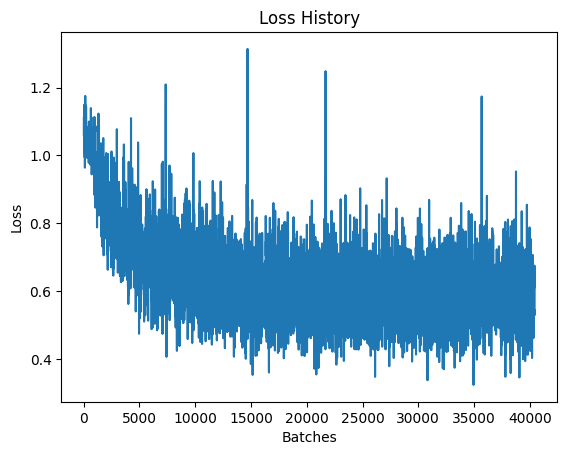

In [18]:
# Loss history plot
x = [epoch[0] for epoch in loss_history]
y = [epoch[1] for epoch in loss_history]
plt.plot(x, y, label='Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

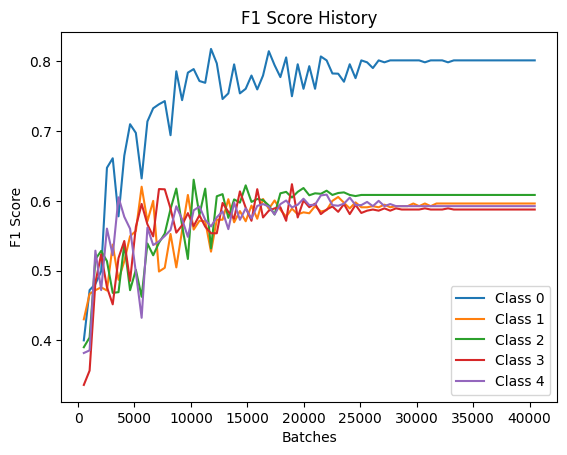

In [19]:
# F1 score plot
x = [epoch[0] for epoch in acc_history]
y = [epoch[1]['f1_per_class'] for epoch in acc_history]

plt.plot(x, y)
plt.xlabel('Batches')
plt.legend([f'Class {i}' for i in range(len(y[0]))])
plt.ylabel('F1 Score')
plt.title('F1 Score History')
plt.show()

Text(0.5, 1.0, 'Hamming Loss per class')

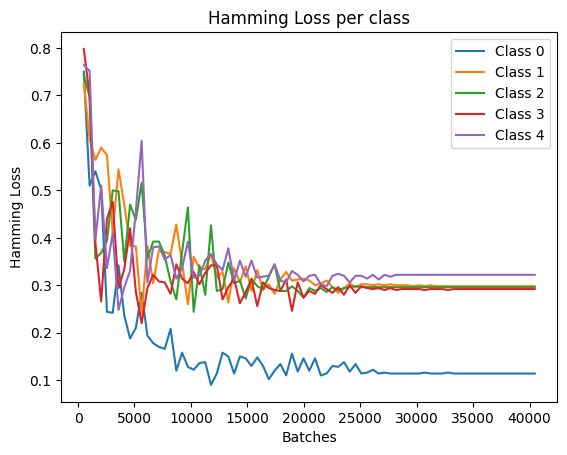

In [20]:
# Hamming accuracy plot
x = [epoch[0] for epoch in acc_history]
y = [epoch[1]['hamming_loss_per_class'] for epoch in acc_history]

plt.plot(x, y)
plt.legend([f'Class {i}' for i in range(len(y[0]))])
plt.xlabel('Batches')
plt.ylabel('Hamming Loss')
#plt.yscale('log')
plt.title('Hamming Loss per class')

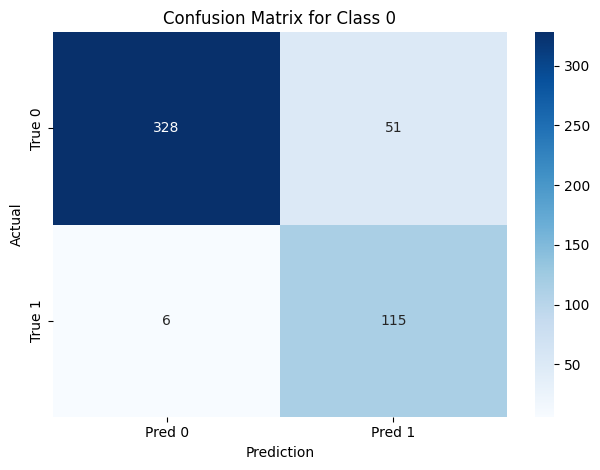

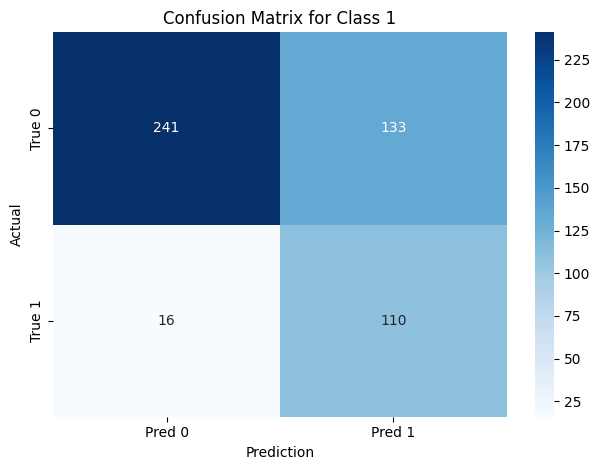

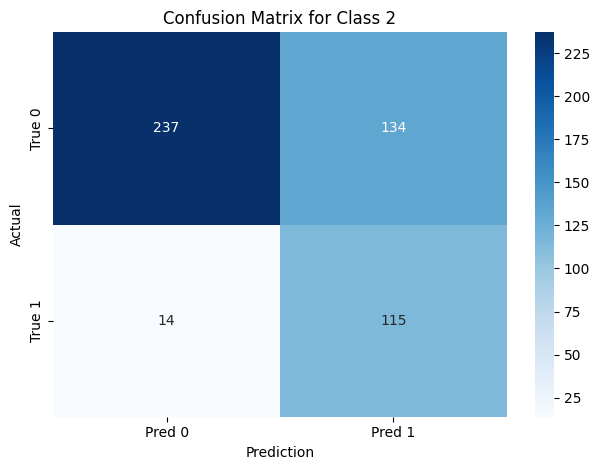

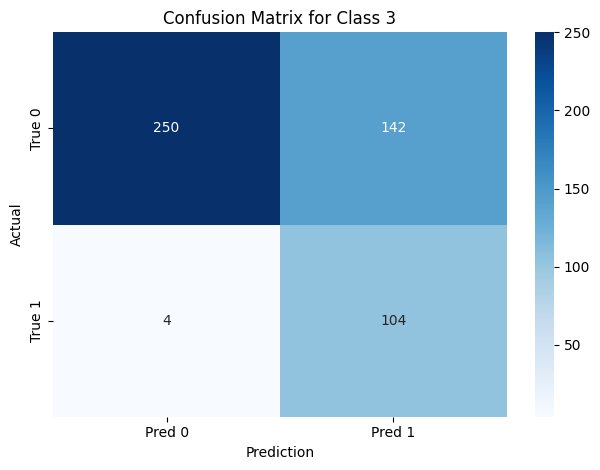

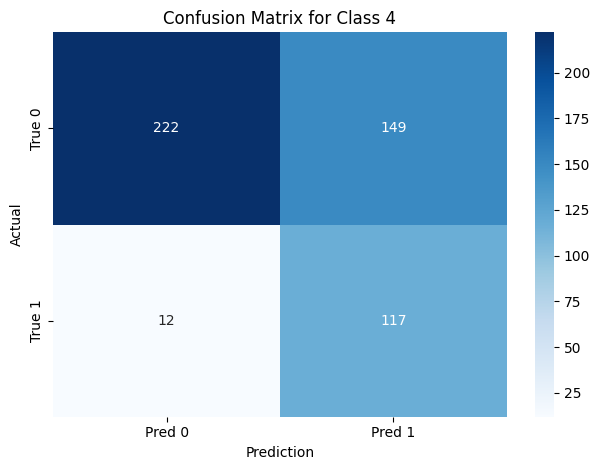

In [21]:
# Load history
acc_history = np.load(f'{save_path}/acc_history.npy', allow_pickle=True)

# Choose the latest evaluation (last checkpoint)
last_eval = acc_history[-1][1]  # acc_history = [batch_count, eval_dict]

for i in range(5):
   # Extract TP, FP, FN, TN
   tp = last_eval["tp"][i]
   fp = last_eval["fp"][i]
   fn = last_eval["fn"][i]
   tn = last_eval["tn"][i]

   # Create confusion matrix
   cm = np.array([[tn, fp],
                  [fn, tp]])

   # Plot
   sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=["Pred 0", "Pred 1"],
               yticklabels=["True 0", "True 1"])
   plt.title(f"Confusion Matrix for Class {i}")
   plt.xlabel("Prediction")
   plt.ylabel("Actual")
   plt.tight_layout()
   plt.show()

# Threshold Tuning

In [43]:
resume_from = f"{save_path}/checkpoint_ep7_b5285.pt"
resume_lr = 1e-4

model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
trainer = Trainer(model, device, accum_steps=accum_steps, lr=starting_lr, pos_weights=pos_weights, checkpoint_interval=checkpoint_interval, resume_checkpoint=resume_from)
# Final model evaluation
results = trainer.evaluate(train_dataloader)

# Save optimal thresholds for reuse
np.save(f"{save_path}/thresholds.npy", results["optimal_thresholds"])


/home/jiacheng/dl-proj/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Resuming from epoch 7 batch 5286
🔍 Optimal thresholds per class: [0.65 0.65 0.6  0.65 0.6 ]


In [39]:
# Load final model checkpoint
resume_from = f"{save_path}/checkpoint_ep7_b4773.pt"  # Replace with best one
model = ECGCombined(d_input=d_input, d_model=d_model, num_classes=num_classes, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)
trainer = Trainer(model, device, pos_weights=pos_weights, resume_checkpoint=resume_from)

# Load optimal thresholds
thresholds = np.load(f"{save_path}/thresholds.npy")

# Evaluate with custom thresholds
def evaluate_with_custom_thresholds(trainer, dataloader, thresholds):
    trainer.model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(trainer.device), labels.to(trainer.device)
            outputs = trainer.model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    preds = (all_probs >= thresholds).astype(int)

    f1_per_class = f1_score(all_labels, preds, average=None)
    print("F1 score with tuned thresholds:", f1_per_class)

evaluate_with_custom_thresholds(trainer, test_dataloader, thresholds)


/home/jiacheng/dl-proj/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Resuming from epoch 7 batch 4774
F1 score with tuned thresholds: [0.80321285 0.69565217 0.61417323 0.78764479 0.6119403 ]


In [40]:
def plot_multilabel_conf_matrices(y_true, y_pred, class_names=None):
    confs = multilabel_confusion_matrix(y_true, y_pred)
    
    for i, cm in enumerate(confs):
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        title = f"Class {i}" if class_names is None else f"{class_names[i]}"
        plt.title(f"Confusion Matrix: {title}")
        plt.show()


🔍 Optimal thresholds per class: [0.65 0.6  0.65 0.7  0.55]


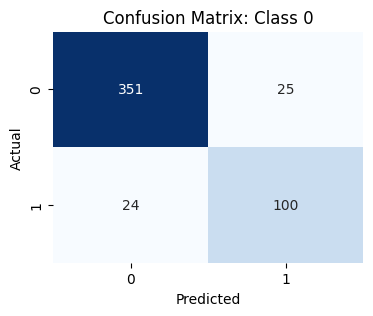

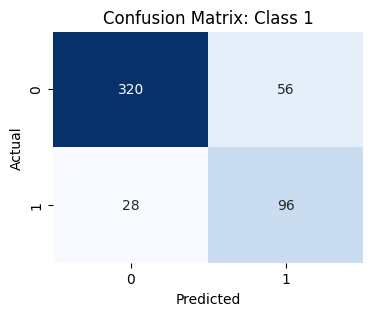

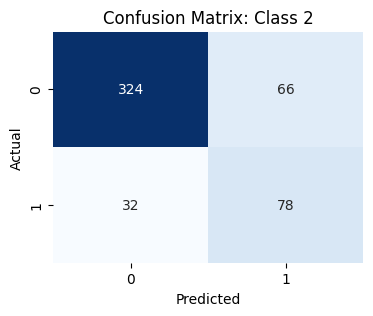

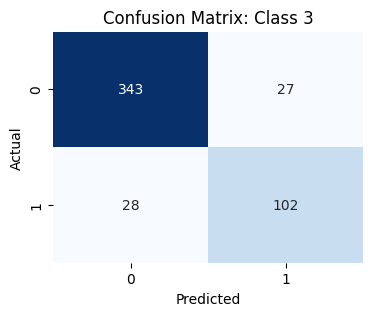

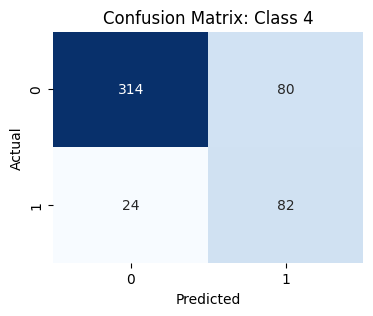

In [41]:
results = trainer.evaluate(test_dataloader)
thresholds = np.load(f"{save_path}/thresholds.npy")

# Redo predictions using new thresholds
all_probs, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.vstack(all_labels)
y_pred = (all_probs >= thresholds).astype(int)

# Plot confusion matrices
plot_multilabel_conf_matrices(all_labels, y_pred)